# 多目的最適化

最適化したい目的関数が複数ある場合は、多目的最適化を利用することができます。  

PHYSBOでは、**パレート解** を効率的に求めるためベイズ最適化手法を実装しています。  

多目的最適化では、解の大小関係 $\prec$ を以下のように定義します。  
ここで、$y$, $y^{'}$ は $p$ 個の目的関数値からなるベクトルで、 $y = (y_1,...,y_p), y^{'} = (y^{'}_1,...,y^{'}_p)$ とします。  

$y \prec y^{'}$ $\Longleftrightarrow$ $\forall \ i \le p$, $y_i \le y^{'}_i  \land \exists \ j \le p$, $y_j \lt y^{'}_j$ 

パレート解とは、上記の大小関係の上で、自身よりも大きな解がないような解を指します。  
目的関数間にトレードオフが存在する場合は、パレート解は複数存在するため、それらを効率的に求めることが課題となります。

In [1]:
import numpy as np
import physbo
import matplotlib.pyplot as plt
%matplotlib inline

## テスト関数

本チュートリアルでは、多目的最適化のベンチマーク関数である VLMOP2 を利用します。  
目的関数の数は2つです。

オリジナルの関数は最小化問題用のため、-1を掛けたものを目的関数とします。

- 参考  
Van Veldhuizen, David A. Multiobjective evolutionary algorithms: classifications, analyses, and new innovations. No. AFIT/DS/ENG/99-01. AIR FORCE INST OF TECH WRIGHT-PATTERSONAFB OH SCHOOL OF ENGINEERING, 1999.

In [2]:
def vlmop2_minus(x):
    n = x.shape[1]
    y1 = 1 - np.exp(-1 * np.sum((x - 1/np.sqrt(n)) ** 2, axis = 1))
    y2 = 1 - np.exp(-1 * np.sum((x + 1/np.sqrt(n)) ** 2, axis = 1))

    return np.c_[-y1, -y2]

## 探索候補データの準備

入力空間は 2次元とし、[-2, 2] × [-2, 2] の上で候補点をでグリッド状に生成します。

In [3]:
import itertools
a = np.linspace(-2,2,101)
test_X = np.array(list(itertools.product(a, a)))

In [4]:
test_X

array([[-2.  , -2.  ],
       [-2.  , -1.96],
       [-2.  , -1.92],
       ...,
       [ 2.  ,  1.92],
       [ 2.  ,  1.96],
       [ 2.  ,  2.  ]])

In [5]:
test_X.shape

(10201, 2)

## simulator の定義

In [6]:
class simlator(object):
    def __init__(self, X):
        self.t = vlmop2_minus(X)
    
    def __call__( self, action):
        return self.t[action]

In [7]:
simu = simlator(test_X)

## 関数のプロット

2つの目的関数をそれぞれプロットしてみましょう。  
1つ目の目的関数は右下にピークがあり、2つ目の目的関数は左上にピークがあるため、トレードオフがある状態となっています。

- 1つ目の目的関数

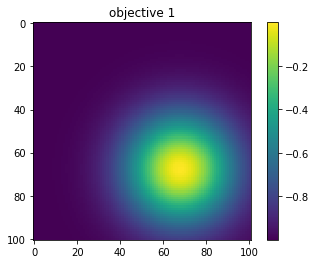

In [8]:
plt.figure()
plt.imshow(simu.t[:,0].reshape((101,101)))
plt.title("objective 1")
plt.colorbar()
plt.show()

- 2つ目の目的関数

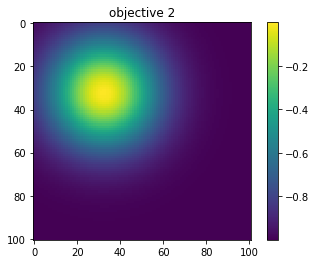

In [9]:
# plot objective 2
plt.figure()
plt.imshow(simu.t[:,1].reshape((101,101)))
plt.title("objective 2")
plt.colorbar()
plt.show()

## 最適化の実行

### policy のセット

多目的最適化用の `policy_mo` を利用します。  
`num_objectives` に目的関数の数を指定してください。

In [10]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

通常の `policy` (目的関数が1つの場合）と同じく、`random_search` または `bayes_search` メソッドを呼ぶことで最適化を行います。  
基本的なAPIや利用方法は `policy` とおおよそ共通しています。

### ランダムサーチ

In [11]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res = policy.random_search(max_num_probes=50, simulator=simu)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

目的関数の評価値(の array) とそのときの action ID が表示されます。  
また、パレート解集合 (Pareto set) が更新されたときにメッセージを表示します。

Pareto set が更新された際に中身を表示したい場合は、`disp_pareto_set=True` と指定します。  
Pareto set は1つ目の目的関数値の昇順でソートされています。また、steps はパレート解が追加された際のステップ数を示しています。

In [12]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)
res = policy.random_search(max_num_probes=50, simulator=simu, disp_pareto_set=True)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]] (steps = [1]) 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]
 [-0.99789981 -0.99866427]] (steps = [1 2]) 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   current Pareto set = [[-0.99090897 -0.46609239]] (steps = [3]) 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]] (steps = [4]) 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.67969326 -0.99981691]] (steps = [4 5]) 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.45601619 -0.99848443]] (steps =

### 結果の確認

- 評価値の履歴

In [13]:
res.fx[0:res.num_runs]

array([[-0.99973003, -0.62334035],
       [-0.99789981, -0.99866427],
       [-0.99090897, -0.46609239],
       [-0.92633083, -0.29208351],
       [-0.67969326, -0.99981691],
       [-0.45601619, -0.99848443],
       [-0.92670204, -0.71508873],
       [-0.58233995, -0.99952931],
       [-0.99848229, -0.96780195],
       [-0.80479332, -0.99994946],
       [-0.99700074, -0.99847873],
       [-0.9992592 , -0.93891121],
       [-0.19963873, -0.93357674],
       [-0.98046765, -0.99294428],
       [-0.99602549, -0.98620358],
       [-0.99957128, -0.9973798 ],
       [-0.52191048, -0.72845916],
       [-0.99916441, -0.40869572],
       [-0.99480122, -0.7565076 ],
       [-0.63329589, -0.63329589],
       [-0.95437918, -0.80142908],
       [-0.99899466, -0.96646532],
       [-0.19473522, -0.99445365],
       [-0.99969529, -0.52395588],
       [-0.59106078, -0.79258035],
       [-0.78231041, -0.99997141],
       [-0.99955573, -0.99930147],
       [-0.99825097, -0.99875436],
       [-0.65387719,

- パレート解の取得

In [14]:
front, front_num = res.export_pareto_front()
front, front_num

(array([[-0.95713719, -0.09067194],
        [-0.92633083, -0.29208351],
        [-0.63329589, -0.63329589],
        [-0.52191048, -0.72845916],
        [-0.26132949, -0.87913689],
        [-0.17190645, -0.91382463]]),
 array([40,  3, 19, 16, 29, 41]))

- パレート解のプロット例

In [15]:
def plot_pareto_front(res):
    points = res.fx[0:res.num_runs]
    front, front_num = res.export_pareto_front()
    cl = ["blue"]*len(points)
    for i in front_num:
        cl[i] = "red"

    plt.figure(figsize=(7, 7))
    plt.scatter(points[:,0], points[:,1], c = cl)
    plt.title('Pareto front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')

赤のプロットがパレート解です。

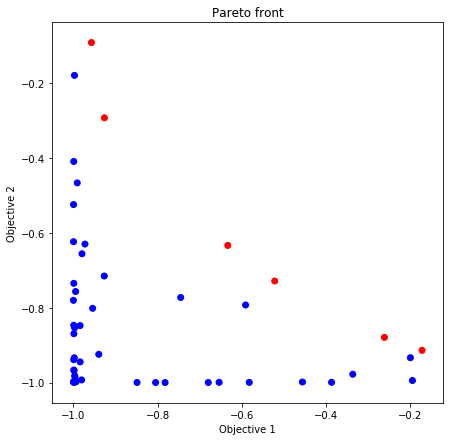

In [16]:
plot_pareto_front(res)

## ベイズ最適化

多目的の場合の `bayes_search` では、`score` には以下のいずれかを指定します。

- HVPI (Hypervolume-based Probability of Improvement)
- EHVI (Expected Hyper-Volume Improvement)
- TS (Thompson Sampling)

以下、score を変えてそれぞれ 50回 (ランダムサーチ10回 + ベイズ最適化 40回) 評価を行います。

### HVPI (Hypervolume-based Probability of Improvement)

多次元の目的関数空間における非劣解領域 (non-dominated region) の改善確率を score として求めます。  

- 参照  
Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [17]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res = policy.random_search(max_num_probes=10, simulator=simu)
res = policy.bayes_search(max_num_probes=40, simulator=simu, score='HVPI', interval=10)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

0036-th step: f(x) = [-0.95078624 -0.06762287] (action = 3774)
   Pareto set updated.
   the number of Pareto frontiers = 25 

0037-th step: f(x) = [-0.17190645 -0.91382463] (action = 6120)
   Pareto set updated.
   the number of Pareto frontiers = 26 

0038-th step: f(x) = [-0.35362632 -0.83371008] (action = 5712)
   Pareto set updated.
   the number of Pareto frontiers = 27 

0039-th step: f(x) = [-0.25896196 -0.87874951] (action = 5916)
   Pareto set updated.
   the number of Pareto frontiers = 28 

0040-th step: f(x) = [-0.06762287 -0.95078624] (action = 6426)
   Pareto set updated.
   the number of Pareto frontiers = 29 

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood -68.14422496160623
50 -th epoch marginal likelihood -69.74821313678461
100 -th epoch marginal likelihood -71.16364516263143
150 -th epoch marginal likelihood -72.4563341663758
200 -th epoch marginal likelihood -73.7042727789136
250 -th epoc

- パレート解のプロット

パレート解が多く求まっていることが分かります。

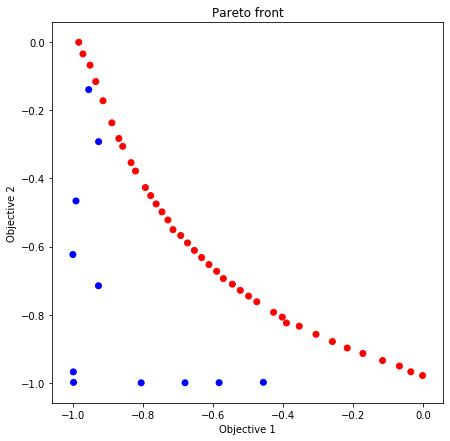

In [18]:
plot_pareto_front(res)

- 劣解領域 (diminated region) の体積を計算

`res.pareto.volume_in_dominance(ref_min, ref_max)` により劣解領域の体積を計算できます。  
この値が大きいと、より良いパレート解が多く求まっていることの指標の一つとなります。

`ref_min`, `ref_max` により、計算対象としたい領域の矩形(hyper-rectangle) を指定します。

In [19]:
res.pareto.volume_in_dominance([-1,-1],[0,0])

0.32877907991633726

### EHVI (Expected Hyper-Volume Improvement)

多次元の目的関数空間における非劣解領域 (non-dominated region) の改善期待値を score として求めます。  

- 参照  
Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [20]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res = policy.random_search(max_num_probes=10, simulator=simu)
res = policy.bayes_search(max_num_probes=40, simulator=simu, score='EHVI', interval=10)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

0037-th step: f(x) = [-0.49811725 -0.7454381 ] (action = 5406)
   Pareto set updated.
   the number of Pareto frontiers = 21 

0038-th step: f(x) = [-9.00606888e-04 -9.80950206e-01] (action = 6835)
   Pareto set updated.
   the number of Pareto frontiers = 22 

0039-th step: f(x) = [-0.98483911 -0.00295954] (action = 3263)
0040-th step: f(x) = [-0.00557976 -0.98649648] (action = 7038)
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood -60.35218224451242
50 -th epoch marginal likelihood -62.313242307036454
100 -th epoch marginal likelihood -64.03507521142389
150 -th epoch marginal likelihood -65.58859324220893
200 -th epoch marginal likelihood -66.9958020672912
250 -th epoch marginal likelihood -68.30020077573666
300 -th epoch marginal likelihood -69.54647337575284
350 -th epoch marginal likelihood -70.76184092943672
400 -th epoch marginal likelihood -71.95882264318007
450 -th epoch marginal likelihood -73.1433812

- パレート解のプロット

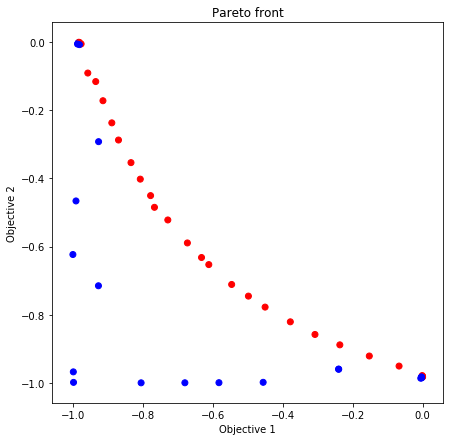

In [21]:
plot_pareto_front(res)

- 劣解領域の体積

In [22]:
res.pareto.volume_in_dominance([-1,-1],[0,0])

0.3200467412741881

### TS (Thompson Sampling)

単目的の場合の Thompson Sampling では、各候補(test_X)について、目的関数の事後分布からサンプリングを行い、値が最大となる候補を次の探索点として推薦します。  
多目的の場合は、サンプリングした値についてパレートルールの上で最大となる候補、つまりパレート最適な候補の中からランダムに1つ選択して次の探索点とします。

- 参照  
Yahyaa, Saba Q., and Bernard Manderick. "Thompson sampling for multi-objective multi-armed bandits problem." Proc. Eur. Symp. Artif. Neural Netw., Comput. Intell. Mach. Learn.. 2015.

In [24]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res = policy.random_search(max_num_probes=10, simulator=simu)
res = policy.bayes_search(max_num_probes=40, simulator=simu, score='TS', interval=10, num_rand_basis=5000)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

400 -th epoch marginal likelihood -69.1623982016732
450 -th epoch marginal likelihood -69.80850190860664
500 -th epoch marginal likelihood -70.44624875031158
Done

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood -46.614138208164405
50 -th epoch marginal likelihood -48.14999941208069
100 -th epoch marginal likelihood -49.578864244694195
150 -th epoch marginal likelihood -50.88205604013312
200 -th epoch marginal likelihood -52.05533619926354
250 -th epoch marginal likelihood -53.11693549156235
300 -th epoch marginal likelihood -54.09625721870218
350 -th epoch marginal likelihood -55.01736129337644
400 -th epoch marginal likelihood -55.89365983770462
450 -th epoch marginal likelihood -56.73271757611427
500 -th epoch marginal likelihood -57.54052768605145
Done

0041-th step: f(x) = [-0.99938407 -0.98833098] (action = 7474)
0042-th step: f(x) = [-0.99615554 -0.21626044] (action = 2053)
0043-th step: f(x) = [-0.9916

- パレート解のプロット

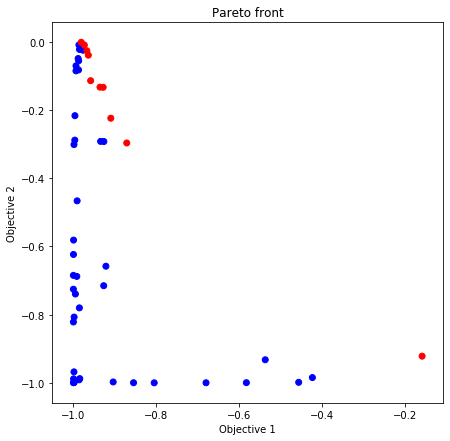

In [25]:
plot_pareto_front(res)

- 劣解領域の体積

In [26]:
res.pareto.volume_in_dominance([-1,-1],[0,0])

0.16415446221006114